In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape to 3 channels and normalize
train_images = np.stack([train_images]*3, axis=-1) / 255.0
test_images = np.stack([test_images]*3, axis=-1) / 255.0

# Resize images to 32x32
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

<ipython-input-2-7cbe09b64ad8>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 68s 40ms/step - accuracy: 0.4444 - loss: 1.8272 - val_accuracy: 0.6039 - val_loss: 1.2973
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.6084 - loss: 1.2619 - val_accuracy: 0.6373 - val_loss: 1.1387
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.6362 - loss: 1.1266 - val_accuracy: 0.6532 - val_loss: 1.0728
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.6490 - loss: 1.0784 - val_accuracy: 0.6597 - val_loss: 1.0374
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.6559 - loss: 1.0472 - val_accuracy: 0.6662 - val_loss: 1.0146
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 98s 49ms/step - accuracy: 0.6602 - loss: 1.0274 - val_accuracy: 0.6679 - val_loss: 0.9999
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 66s 39ms/step - accuracy: 0.6596 - loss: 1.0120 - val_accuracy: 0.6703 - val_loss: 0.9903
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.6662 -

In [4]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 186s 114ms/step - accuracy: 0.2326 - loss: 10.8395 - val_accuracy: 0.1593 - val_loss: 10.4631
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 202s 114ms/step - accuracy: 0.4806 - loss: 2.6292 - val_accuracy: 0.2993 - val_loss: 2.3348
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 201s 114ms/step - accuracy: 0.6035 - loss: 1.5421 - val_accuracy: 0.6557 - val_loss: 1.1085
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 203s 115ms/step - accuracy: 0.6955 - loss: 1.0872 - val_accuracy: 0.8071 - val_loss: 0.6749
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 169s 113ms/step - accuracy: 0.7577 - loss: 0.8119 - val_accuracy: 0.8506 - val_loss: 0.5207


In [5]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8393 - loss: 0.5604
Test loss: 0.5303705334663391
Test accuracy: 0.8481000065803528


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step


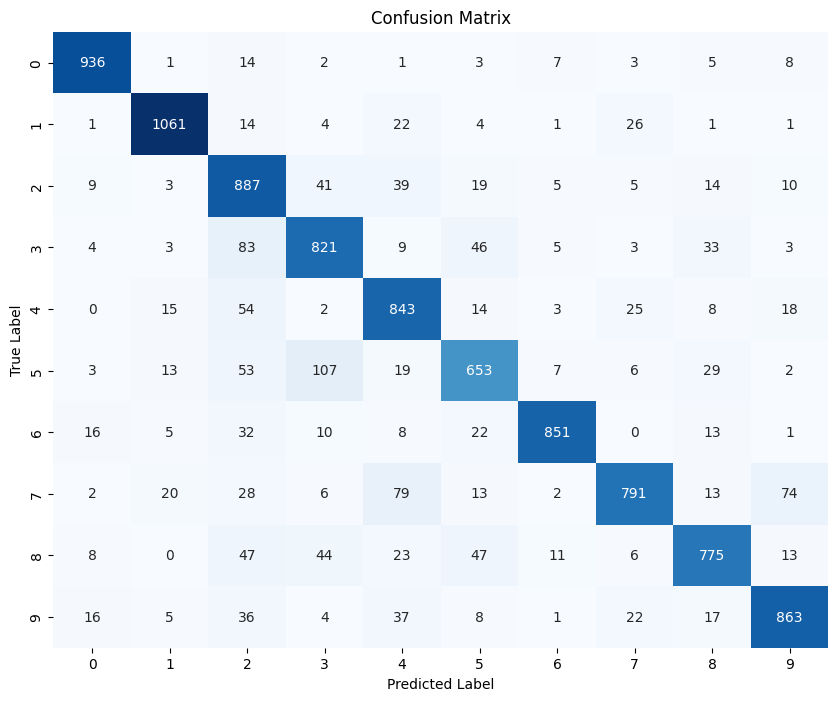

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Plot confusion matrix
cm = confusion_matrix(test_true_classes, test_predictions_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

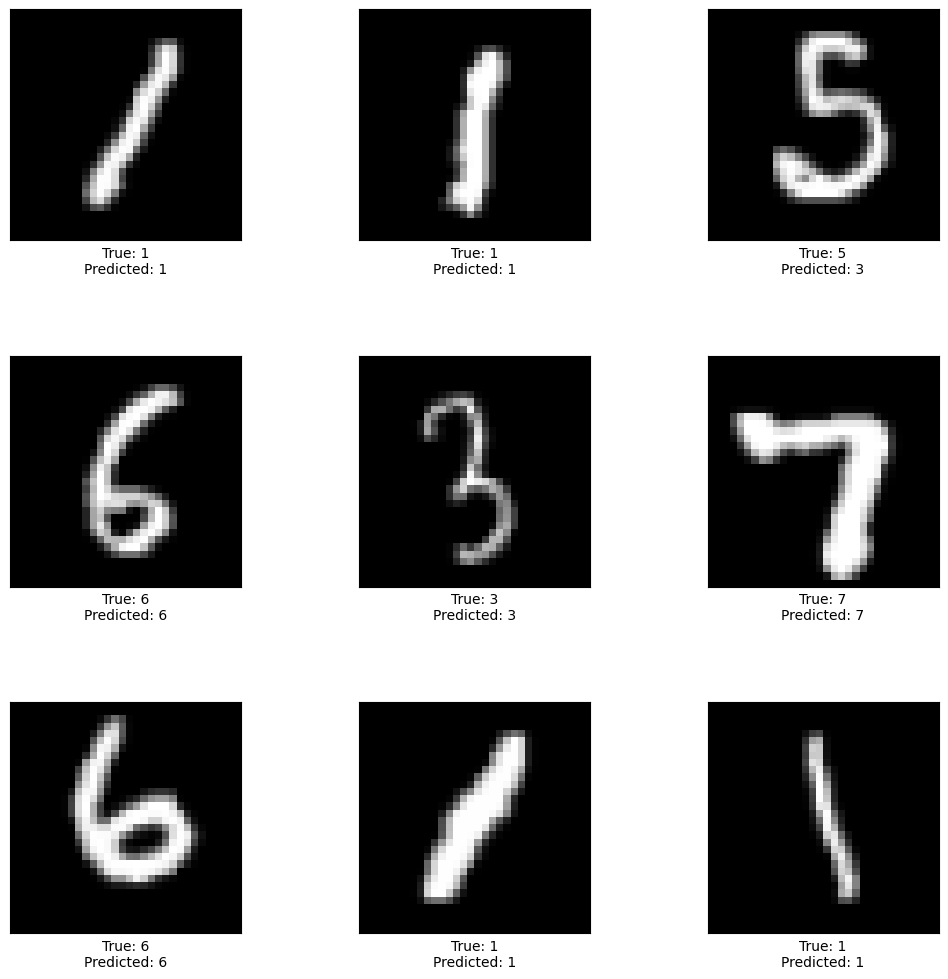

In [7]:
def display_sample(sample_images, sample_labels, sample_predictions):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].reshape(32, 32), cmap='gray')
        ax.set_xlabel(f"True: {sample_labels[i]}\nPredicted: {sample_predictions[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Convert RGB to grayscale for visualization
test_images_gray = np.dot(test_images[...,:3], [0.2989, 0.5870, 0.1140])

# Select and display a sample
random_indices = np.random.choice(len(test_images_gray), 9, replace=False)
sample_images = test_images_gray[random_indices]
sample_labels = test_true_classes[random_indices]
sample_predictions = test_predictions_classes[random_indices]
display_sample(sample_images, sample_labels, sample_predictions)